Code to generate von Mises distributions and fits and trying to understand its properties.

A von Mises distribution is a unimodal distribution on a circular space. It is a close approximation to a wrapped normal distribution, which is the circular analogue of the normal distribution.
The von Mises probability density function for the angle $\varphi$ is given by the following equation
                                                $P(\varphi \mid \mu,\kappa)$ = $\frac{1}{2(\pi)I0(\kappa)}$exp($\kappa$cos($\varphi - \mu))$
                                                
The parameters μ and $\kappa$  are analogous to $\mu$ and $\sigma2$ (the mean and variance) in the normal distribution:
$\mu$ is a measure of location (the distribution is clustered around $\mu$), and $\kappa$ is a measure of concentration (a reciprocal measure of dispersion, so $\frac{1}{\kappa}$  is analogous to $\sigma2$ ).
If $\kappa$ = 0, the distribution is uniform, and for small $\kappa$ values, it is close to uniform.
If $\kappa$  is large, the distribution becomes very concentrated about the angle $\mu$ with $\kappa$ being a measure of the concentration. In fact, as $\kappa$ increases, the distribution approaches a normal distribution in $\varphi$ with mean $\mu$ and variance $\frac{1}{\kappa}$.

In our system, the compass of the fly, we are approximating the heading encoding with a von Mises distribution. Let's see what ths distribution would look like for different parameter values.

In [92]:
# Import relevant modules
from scipy.stats import vonmises, vonmises_line
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns; sns.set()
from scipy.signal import find_peaks, peak_widths, peak_prominences
import time
from tqdm import tqdm, tqdm_gui
from scipy.ndimage import gaussian_filter

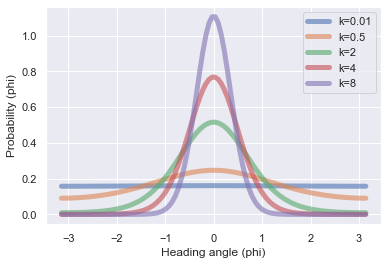

In [131]:
# Simulate and plot a von Mises distribution with u = 0, and different kappa values
fig, ax = plt.subplots(1, 1)

kappa = np.array([0.01, 0.5, 2, 4, 8])
#mean, var, skew, kurt = vonmises.stats(kappa, moments='mvsk')

x = np.linspace(vonmises.ppf(0.000000001, kappa),vonmises.ppf(0.999999999,kappa), 100)
values = ('k=0.01','k=0.5','k=2','k=4','k=8')
ax.plot(x, vonmises.pdf(x, kappa),lw=5, alpha=0.6)
ax.legend(values)
plt.xlabel('Heading angle (phi)')
plt.ylabel('Probability (phi)')
plt.savefig("vonMisesDist.png", dpi=150)

- I don't understand the differences between vonmises and vonmises_line
- I can't generate the line for $\kappa$ = 0 and I think it's because gives the equation, for kappa = 0 the fist might not be solved? I've used a very small number instead.

We can use this von Mises distribution to fit our imaging data. One problem is that the imaging was done in the PB, and therefore has 2 periods instead of 1. I need to somehow combine the data from the two PB sides to obtain circular data that I can then fit with a von Mises function. Tots suggested:
- take the mean dF/F of the corresponding glomeruli on the right and the left to obtain a better estimate of 1 period
- if one hemisphere gives you way better signal than the other, it might be better to just use that side instead of combining both hemispheres.

In [3]:
mainDir = os.getcwd()

In [94]:
#Load sample data from 1 fly from Jenny's panels on/panels off experiment
os.chdir(mainDir + '\\UncertaintyProject\\JennyPanelsOffExp\\data\\20190329_60D05_6f\\dark trial\\') #move inside of the folder, inside the dark trial folder
file = os.listdir() #get the file names
data = sio.loadmat(file[0], struct_as_record=False) #load the file. This is loaded as a dictionnary, where the data is stored in a dictionnary key called 'data' (you can see this bu running dict.keys())   
flyData = data['data']


Text(154.75, 0.5, 'PB gomerulus')

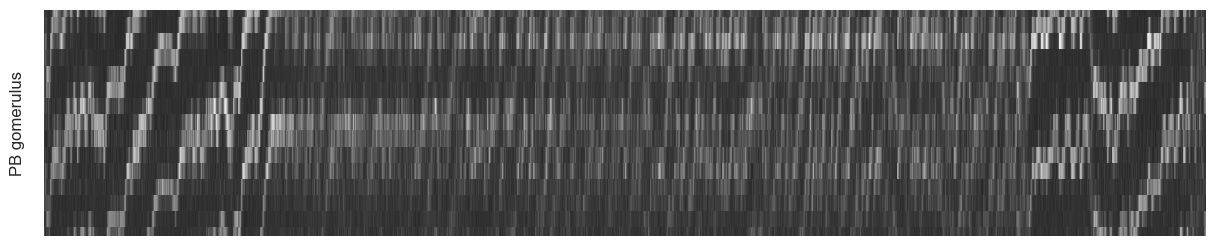

In [95]:
# Plot the DF/F for the full experiment
dff_matrix = flyData[0,0].dff_matrix
my_cmap = sns.dark_palette("white", as_cmap=True)
fig,(ax1) = plt.subplots(1,1, figsize = (15, 3), dpi=100)
g = sns.heatmap(dff_matrix,cmap=my_cmap,ax=ax1, cbar=False)
g.set(xticklabels=[])
g.set(yticklabels=[])
g.set_ylabel('PB gomerulus')

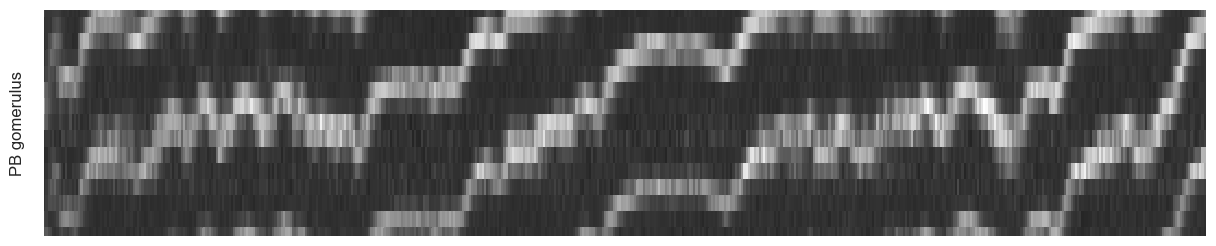

In [133]:
# Let's focus on the first part of the experiment, where the bump is very clear

panelOFF = np.array(np.where(flyData[0,0].fr_y_ds == 1))
StartDark = panelOFF[0,0]
cropped_dff_matrix = flyData[0,0].dff_matrix[:,0:StartDark]
fig,(ax1) = plt.subplots(1,1, figsize = (15, 3), dpi=100)
g = sns.heatmap(cropped_dff_matrix,cmap=my_cmap,ax=ax1, cbar=False)
g.set(xticklabels=[])
g.set(yticklabels=[])
g.set_ylabel('PB gomerulus')
plt.savefig("firstPart.png", dpi=150)

([], <a list of 0 Text xticklabel objects>)

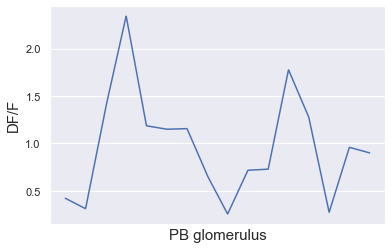

In [97]:
# plot showing the bump in one time frame

exampleData = np.interp(np.linspace(0,15,1000),range(len(cropped_dff_matrix[:,3])),cropped_dff_matrix[:,3])
plt.plot(exampleData)
plt.xlabel('PB glomerulus',fontsize=15)
plt.ylabel('DF/F',fontsize=15)
plt.xticks(ticks=[], labels=[])

([], <a list of 0 Text xticklabel objects>)

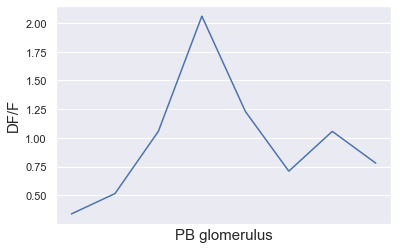

In [121]:
# let's combine the two halves of the PB averaging the DF/F as Tots suggested, and plot that same timepoint

combined_dff = (cropped_dff_matrix[0:8,:] + cropped_dff_matrix[8:16,:])/2

exampleData2 = np.interp(np.linspace(0,7,1000),range(8),combined_dff[:,3])
plt.plot(exampleData2)
plt.xlabel('PB glomerulus',fontsize=15)
plt.ylabel('DF/F',fontsize=15)
plt.xticks(ticks=[], labels=[])

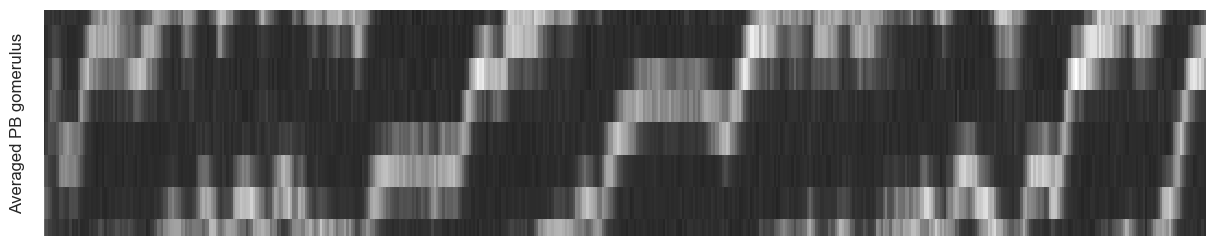

In [134]:
# Let's see what the heatmap looks like

fig,(ax1) = plt.subplots(1,1, figsize = (15, 3), dpi=100)
g = sns.heatmap(combined_dff,cmap=my_cmap,ax=ax1, cbar=False)
g.set(xticklabels=[])
g.set(yticklabels=[])
g.set_ylabel('Averaged PB gomerulus')
plt.savefig("averaged.png", dpi=150)
#I think it looks pretty decent!

In [122]:
# Now let's take our previous example datapoint and fit a von Mises distribution

param = vonmises.fit(exampleData2, fscale=1)
#I believe that this is giving us kappa and mu estimates as the first two arguments of this.
#I don't understand what the scale parameter is, but I read that we had to set it to 1 for it to work properly

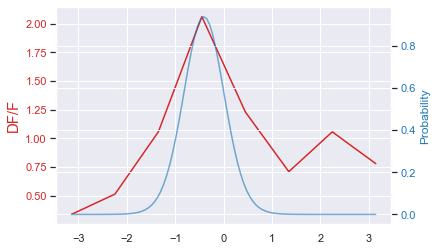

In [140]:
# Let's overlay the fit we got on top of our datapoint

exampleData2 = np.interp(np.linspace(0,7,1000),range(8),combined_dff[:,3])

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(np.linspace(-np.pi,np.pi,1000),exampleData2, color=color)
ax1.set_ylabel('DF/F',fontsize=15, color=color)
#ax1.set_xlabel('Heading angle',fontsize=15)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_xticks(ticks=[], labels=[])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
x = np.linspace(vonmises.ppf(0.000000001, param[0]),vonmises.ppf(0.999999999,param[0]), 100)
fitData = vonmises.pdf(x, param[0], -0.4*param[1])
ax2.plot(x, fitData, alpha=0.6, color=color)
ax2.set_ylabel('Probability', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

plt.savefig("pointFit.png", dpi=150)

I'm not sure how to do to always overlay the plots. Here I've shifted the fit by -$\pi$ but it doesn't work for every time frame

We can then use $\kappa$ as the bump magnitude in our analysis. For the with at half max, we can use python signal detection packages to detect the peak of the von Mises and find the half max from there. Next is an example with the previously plotted datapoint.

Text(0.5, 1.0, 'Example data for one frame')

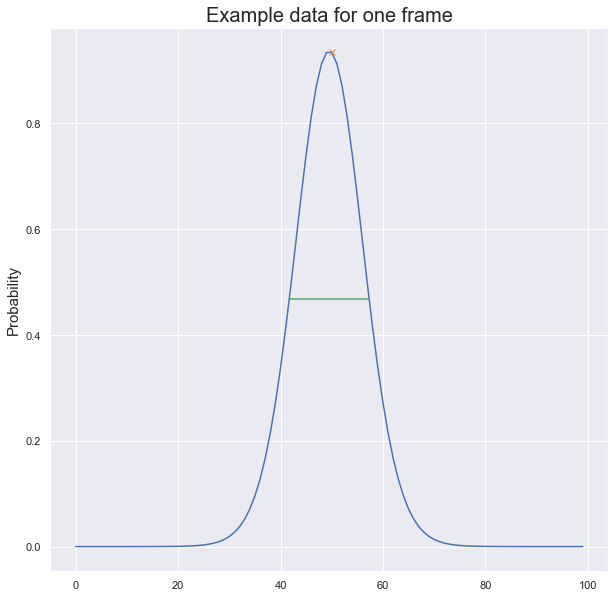

In [128]:
# Find the width at half max for this datapoint

#find the peaks
fitData = vonmises.pdf(x, param[0]) #to find the width at half max, I'll only use k, since u will shift the plot and might crop the peak on the sides, leading to a lower estimate of the width at half max than reality.
peaks, _ = find_peaks(fitData)

#retain the taller peak (1 bump)
peakValues = fitData[peaks]
MinToMaxOrder = np.argsort(peakValues)
MaxToMinOrder = np.flip(MinToMaxOrder)
Peaks = peaks[MaxToMinOrder[0:1]]

#get the width at half max
results_half = peak_widths(fitData, Peaks, rel_height=0.5)

#plot
plt.plot(fitData)
#plt.xlabel('PB glomerulus',fontsize=15)
plt.ylabel('Probability',fontsize=15)
plt.plot(peaks, fitData[peaks], "x")
plt.hlines(*results_half[1:], color="C2")
plt.gcf().set_size_inches(10, 10)
plt.title('Example data for one frame',fontsize = 20)


Using the data from the fly we just loaded, let's now fit all the data points, and compare the bump width at half max across states.

In [151]:
combined_full_dff = (dff_matrix[0:8,:] + dff_matrix[8:16,:])/2
half_width = np.zeros((1,len(combined_full_dff[1])))
bump_mag = np.zeros((1,len(combined_full_dff[1])))

#Add a progress bar
for i in tqdm(range(len(combined_full_dff[1]))): 
    extendedData[:,i] = np.interp(np.linspace(1,7,1000),range(8),combined_full_dff[:,i])
    Params = vonmises.fit(extendedData[:,i], fscale=1)
    bump_mag[0,i] = Params[0]
    x = np.linspace(vonmises.ppf(0.000000001, Params[0]),vonmises.ppf(0.999999999,Params[0]), 100)
    fitData = vonmises.pdf(x, Params[0]) 
    peaks, _ = find_peaks(fitData)
    peakValues = fitData[peaks]
    MinToMaxOrder = np.argsort(peakValues)
    MaxToMinOrder = np.flip(MinToMaxOrder)
    Peaks = peaks[MaxToMinOrder[0:1]]
    results_half = peak_widths(fitData, Peaks, rel_height=0.5)
    half_width[0,i] = results_half[0]
    time.sleep(0.01)
    



  0%|                                                                                         | 0/2751 [00:00<?, ?it/s]

  0%|                                                                                 | 1/2751 [00:00<32:01,  1.43it/s]

  0%|                                                                                 | 2/2751 [00:01<31:48,  1.44it/s]

  0%|                                                                                 | 3/2751 [00:02<32:22,  1.41it/s]

  0%|                                                                                 | 4/2751 [00:02<31:28,  1.45it/s]

  0%|▏                                                                                | 5/2751 [00:03<30:49,  1.48it/s]

  0%|▏                                                                                | 6/2751 [00:04<30:10,  1.52it/s]

  0%|▏                                                                                | 7/2751 [00:04<29:42,  1.54it/s]

  0%|▏                        

KeyboardInterrupt: 

This is giving me the opposite result than the one I was expecting, since the bump magnitude appears greater for uncertain conditions, and the width at half max appears lower. Maybe this is because under uncertain conditions, the fit is not good?

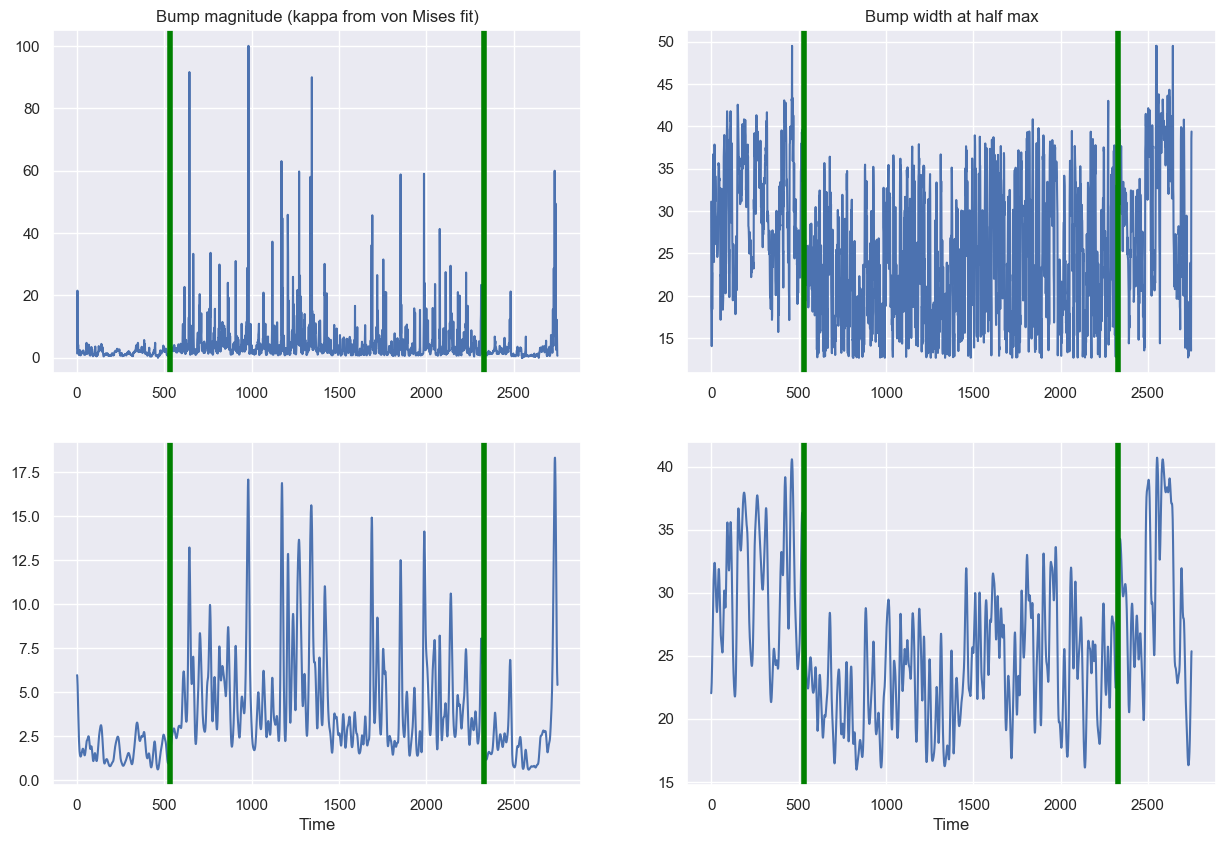

In [141]:
#Plotting the results

EndDark = panelOFF[0,-1]

fig, axs = plt.subplots(2,2, figsize = (15, 10), dpi=100)

axs[0,0].plot(bump_mag)
axs[0,0].set_title('Bump magnitude (kappa from von Mises fit)')
axs[0,0].axvline(x=StartDark, color='green', lw = 4)
axs[0,0].axvline(x=EndDark, color='green', lw = 4)

axs[0,1].plot(half_width)
axs[0,1].set_title('Bump width at half max')
axs[0,1].axvline(x=StartDark, color='green', lw = 4)
axs[0,1].axvline(x=EndDark, color='green', lw = 4)

smoothed_bump_mag = gaussian_filter(bump_mag, sigma=5)
axs[1,0].plot(smoothed_bump_mag)
axs[1,0].set_xlabel('Time')
axs[1,0].axvline(x=StartDark, color='green', lw = 4)
axs[1,0].axvline(x=EndDark, color='green', lw = 4)

smoothed_half_width = gaussian_filter(half_width, sigma=5)
axs[1,1].plot(smoothed_half_width)
axs[1,1].set_xlabel('Time')
axs[1,1].axvline(x=StartDark, color='green', lw = 4)
axs[1,1].axvline(x=EndDark, color='green', lw = 4)

plt.savefig("allDataFit.png", dpi=150)